<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Boston Housing Dataset

*regression*, *supervised machine learning*

**Problem**

The Boston Housing Dataset contains data about 505 neighborhood in Boston and their median housing value, collected by the U.S. Bureau. Data is contained in `housing.csv` file. Our goal is to build models to predict housing value for each neighborhood. 

**Method**

We want to explore SVD concepts to perform a simple linear regressoin.


**References**

* Kaggle most voted notebook: https://www.kaggle.com/prasadperera/the-boston-housing-dataset
* Dr. Steve Brunton's lecture on SVD: https://www.youtube.com/watch?v=vNjLugdaGvs&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=21

## Exploratory Analysis

In [206]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

In [207]:
# Load data
data = pd.read_csv('data/housing.csv')
print(data.describe())
cols = data.columns.tolist()

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     1.269195   13.295257    9.205158    0.140765    1.101175   15.679800   
std      2.399207   23.048697    7.169630    0.312765    1.646991   27.220206   
min      0.000000    0.000000    0.000000    0.000000    0.385000    3.561000   
25%      0.049443    0.000000    3.440000    0.000000    0.449000    5.961500   
50%      0.144655    0.000000    6.960000    0.000000    0.538000    6.322500   
75%      0.819622   18.100000   18.100000    0.000000    0.647000    6.949000   
max      9.966540  100.000000   27.740000    1.000000    7.313000  100.000000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    58.744660    6.173308   78.063241  339.317787   42.614980  332.791107   
std     33.104049    6.4764

In [208]:
# remove missing
data.dropna(inplace=True)
data.shape

(452, 14)

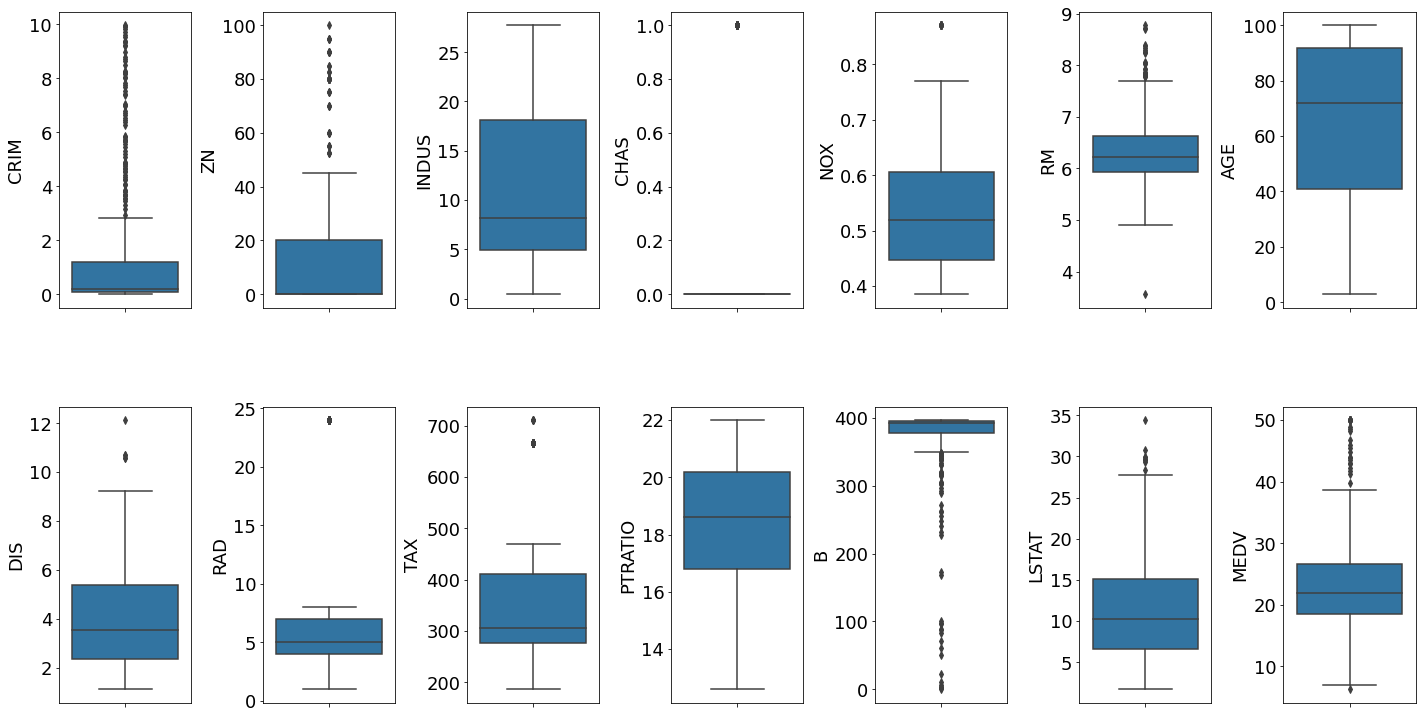

In [209]:
# Visualize features
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [210]:
# see outlier percentage in each column
for k, v in data.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 17.70%
Column ZN outliers = 9.96%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 3.54%
Column RM outliers = 5.09%
Column AGE outliers = 0.00%
Column DIS outliers = 1.11%
Column RAD outliers = 17.26%
Column TAX outliers = 18.36%
Column PTRATIO outliers = 0.00%
Column B outliers = 11.73%
Column LSTAT outliers = 1.99%
Column MEDV outliers = 7.30%


In [197]:
# remove y outliers
#data = data[~(data['MEDV'] >= 50.0)]
#print(np.shape(data))

(490, 14)


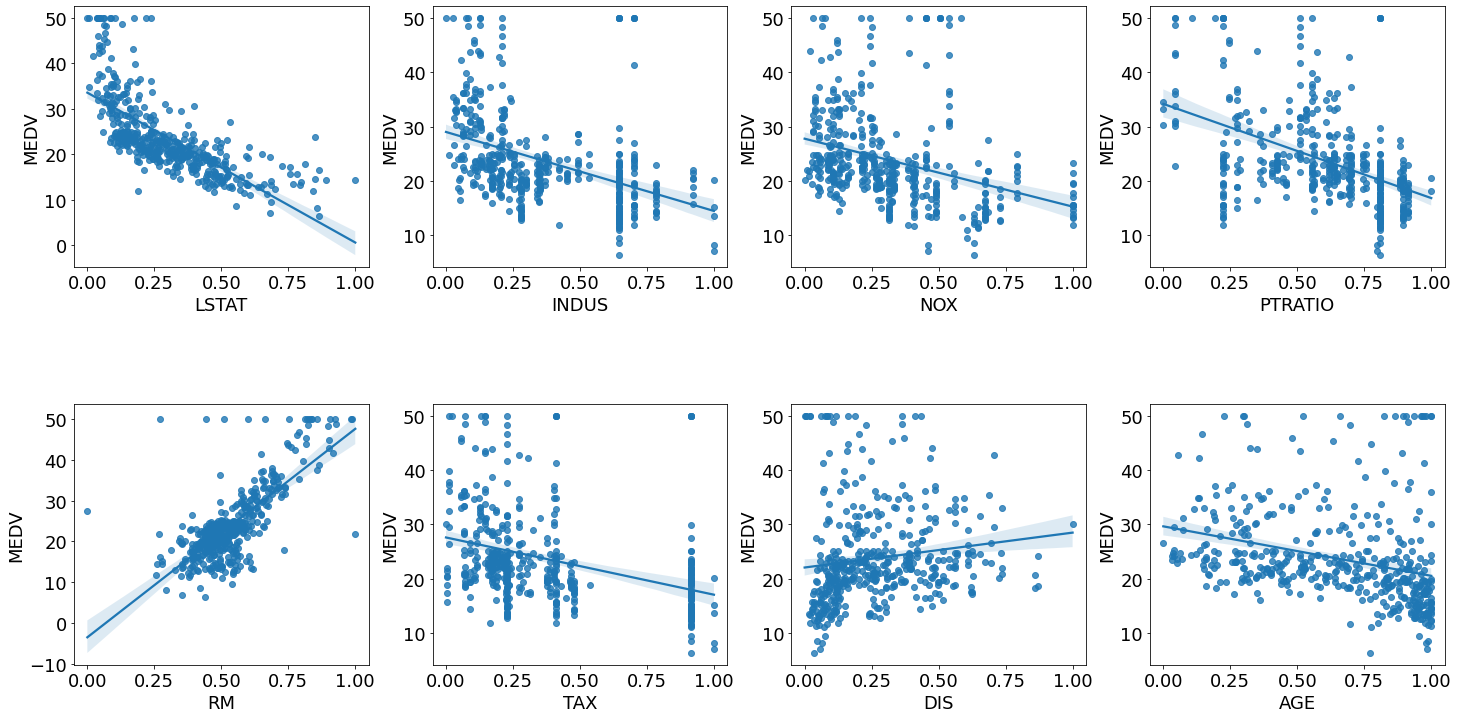

In [211]:
# plot features against pricing
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [199]:
# remove skewnewss in features using log transformation
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

## Linear Regression using SV

In [218]:
H = np.asarray(data)
b = H[:,-1]  # housing values in $1000s
A = H[:,:-1] # use original features
#A = np.asarray(x) # use the preprocessed features

In [219]:
# pad with ones for nonzero offset
A = np.pad(A, [(0,0),(0,1)], mode='constant', constant_values=1)

In [220]:
# split data into training and testing
n = round(A.shape[0] / 2)
btrain = b[:n]
Atrain = A[:n]
btest = b[n:]
Atest = A[n:]

In [221]:
# Solve Ax=b using SVD
U, S, VT = np.linalg.svd(Atrain, full_matrices=False)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ btrain

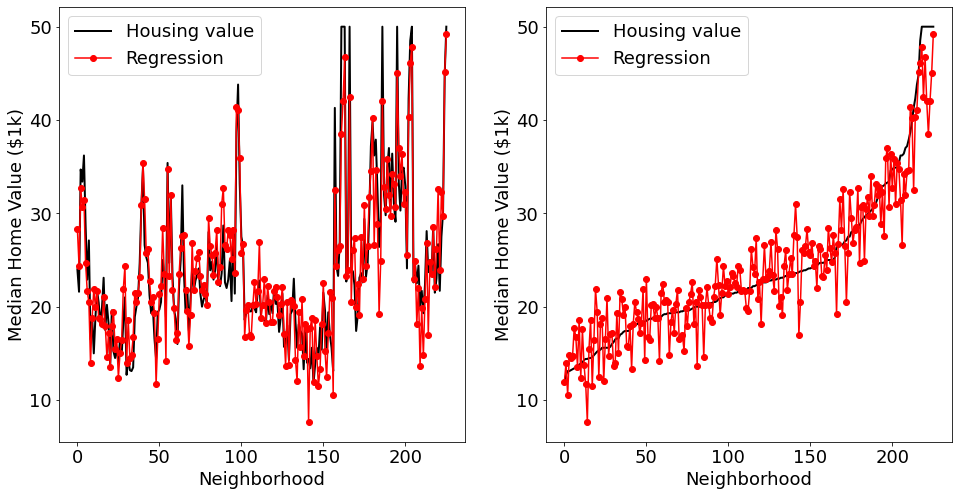

In [222]:
# visualize training data fit
fig = plt.figure()

ax1 = fig.add_subplot(121)
plt.plot(btrain, color='k', linewidth=2, label='Housing value')
plt.plot(Atrain@x, '-o', color='r', markersize=6, label='Regression')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value ($1k)')
plt.legend()

# sort to better see the trend
ax1 = fig.add_subplot(122)
sort_ind = np.argsort(btrain)
plt.plot(btrain[sort_ind], color='k', linewidth=2, label='Housing value')
plt.plot(Atrain[sort_ind,:]@x, '-o', color='r', markersize=6, label='Regression')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value ($1k)')
plt.legend()

plt.show()

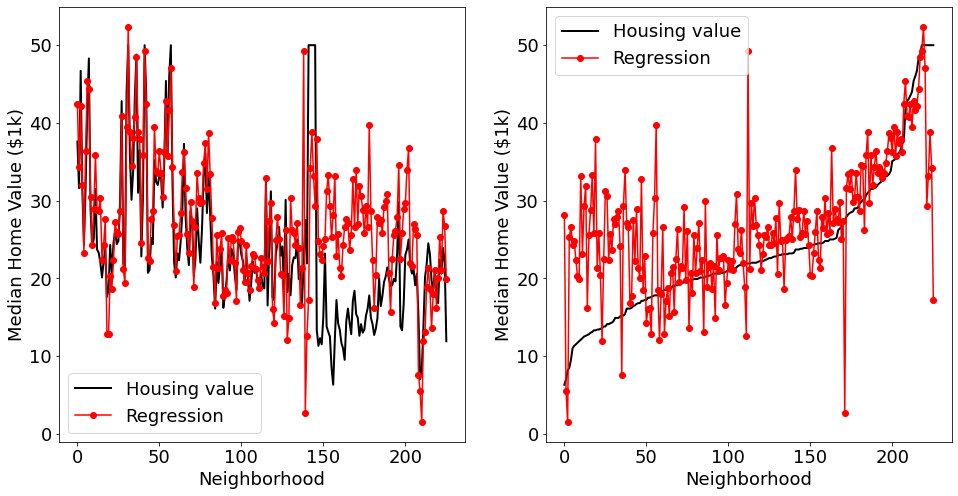

In [223]:
# visualize test data fit
fig = plt.figure()

ax1 = fig.add_subplot(121)
plt.plot(btest, color='k', linewidth=2, label='Housing value')
plt.plot(Atest@x, '-o', color='r', markersize=6, label='Regression')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value ($1k)')
plt.legend()

# sort to better see the trend
ax1 = fig.add_subplot(122)
sort_ind = np.argsort(btest)
plt.plot(btest[sort_ind], color='k', linewidth=2, label='Housing value')
plt.plot(Atest[sort_ind,:]@x, '-o', color='r', markersize=6, label='Regression')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value ($1k)')
plt.legend()

plt.show()

In [224]:
# normalize A to do feature importance comparisons
A_mean = np.mean(Atrain, axis=0).reshape(-1, 1)
A2 = Atrain - np.ones((Atrain.shape[0], 1)) @ A_mean.T
for j in range(Atrain.shape[1]-1):
    A2std = np.std(A2[:, j])
    A2[:, j] = A2[:,j] / A2std
A2[:, -1] = np.ones(Atrain.shape[0])

In [225]:
U, S, VT = np.linalg.svd(A2, full_matrices=False)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ btrain

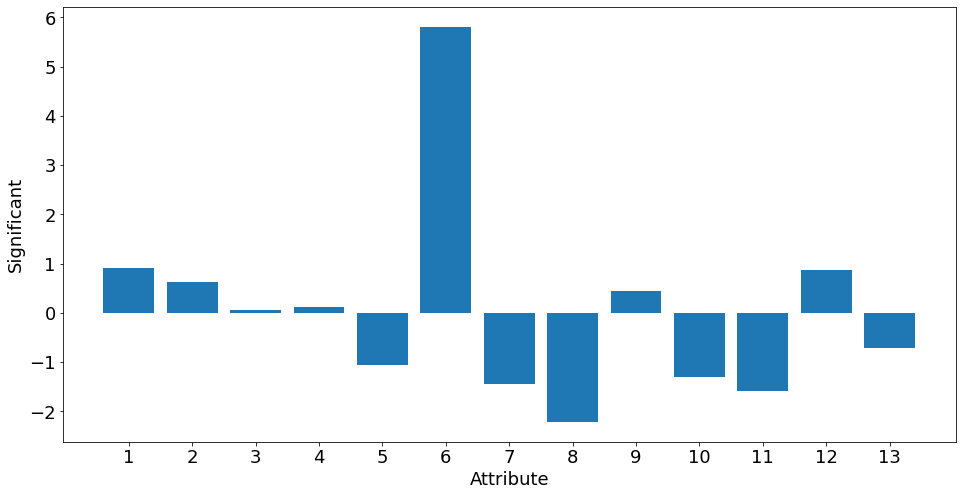

In [226]:
x_tick = range(len(x)-1) + np.ones(len(x)-1)
plt.bar(x_tick, x[:-1])
plt.xlabel('Attribute')
plt.ylabel('Significant')
plt.xticks(x_tick)
plt.show()